# Large Feature Selection

In [1]:
import matplotlib.pyplot as plt
from sklearn_genetic import GAFeatureSelectionCV
from sklearn_genetic.plots import plot_fitness_evolution, plot_histogram_k_features_hof
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, permutation_test_score, cross_validate
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np


c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create a custom dataset with huge number of features
Output only depends on the first features


In [2]:
noise1 = np.random.uniform(-10000, 10000, size=(150, 4_999))
noise2 = np.random.gamma(100, scale=100, size=(150, 4_999))
noise3 = np.random.hypergeometric(5, 10, 5, size=(150, 4_999))
noise4 = np.random.binomial(10, 0.2, size=(150, 4_999))

X = np.hstack((noise1, noise2, noise3, noise4))

y = (X[:, 0] > 0) & (X[:, 1] < 0)

fake_y = np.array([y.copy()]).T
fake_y[np.random.random(150) > 0.8] = 0
X = np.hstack([X, fake_y])
X.shape, y.shape

((150, 19997), (150,))

### Split the training and test data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6)

### Define the GAFeatureSelectionCV options

In [16]:
clf = DecisionTreeClassifier()

evolved_estimator = GAFeatureSelectionCV(
    estimator=clf,
    mutation_probability=0.8,
    cv=5,
    max_features=4,
    population_size=1000,
    generations=35,
    n_jobs=-1,
    verbose=True,
    keep_top_k=100,
    min_genes=2,
)

### Fit the model and see some results

In [17]:
evolved_estimator.fit(X_train, y_train, val_data=(X_test, y_test))
features = evolved_estimator.support_

# Predict only with the subset of selected features
#y_predict_ga = evolved_estimator.predict(X_test)
#accuracy = accuracy_score(y_test, y_predict_ga)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	1000  	0.521872	0.0625607  	0.695      	0.311667   
1  	2000  	0.566305	0.0407463  	0.695      	0.395      
2  	2000  	0.584556	0.0361514  	0.695      	0.425833   
3  	2000  	-99.406 	3160.71    	0.695      	-100000    
4  	2000  	-699.403	8337.32    	0.695      	-100000    
5  	2000  	-499.398	7053.41    	0.695      	-100000    
6  	2000  	-299.393	5469.04    	0.695      	-100000    
7  	2000  	-699.393	8337.32    	0.695      	-100000    
8  	2000  	-1199.39	10888.6    	0.701111   	-100000    
9  	2000  	-499.383	7053.41    	0.701111   	-100000    
10 	2000  	-999.381	9949.94    	0.712222   	-100000    
11 	2000  	-699.376	8337.32    	0.712222   	-100000    
12 	2000  	-1299.38	11327.5    	0.723333   	-100000    
13 	2000  	-999.377	9949.94    	0.712222   	-100000    
14 	2000  	-1299.38	11327.5    	0.712222   	-100000    
15 	2000  	-1099.37	10430.3    	0.712222   	-100000    
16 	2000  	-1199.37	10888.6    	0.723333   	-100

In [18]:
np.where(features)

(array([10071, 15684, 17496, 19996], dtype=int64),)

<AxesSubplot: title={'center': 'Histogram of most selected features in HallOfFame'}, xlabel='count', ylabel='feature'>

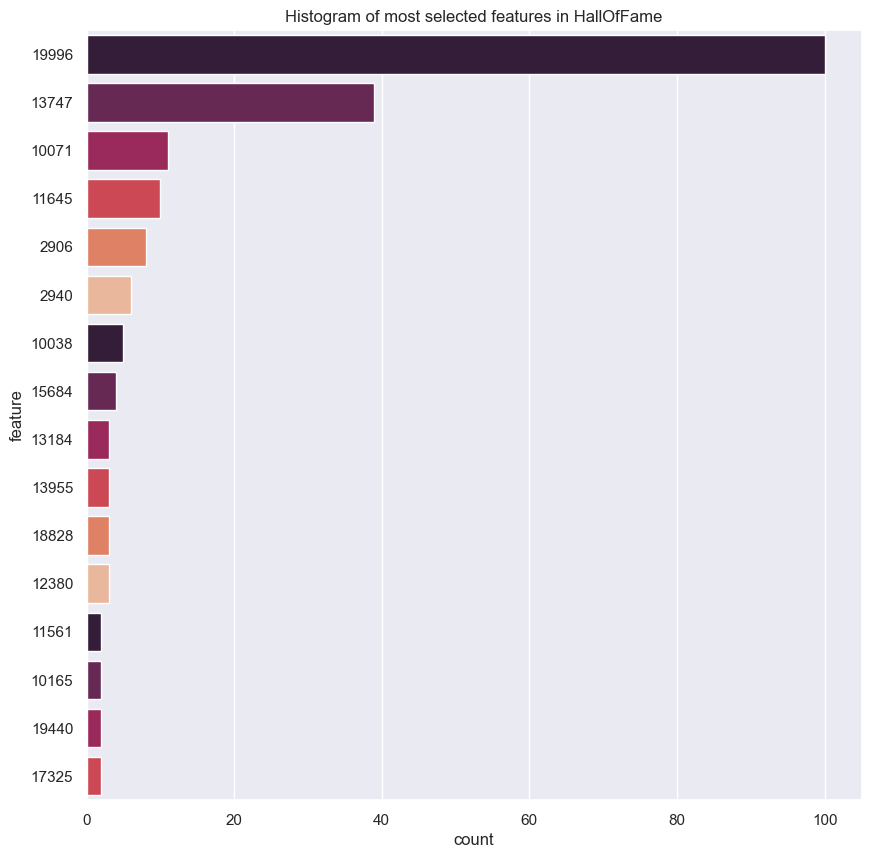

In [19]:
plot_histogram_k_features_hof(evolved_estimator)

Re-doing a feature selection to find a smaller set of features

In [ ]:

clf = DecisionTreeClassifier()

new_estimator = GAFeatureSelectionCV(
    estimator=clf,
    cv=5,
    scoring="accuracy",
    max_features=4,
    population_size=50,
    generations=10,
    n_jobs=-1,
    verbose=True,
    tournament_size=25,
    elitism=True,
)

In [ ]:
new_estimator.fit(X_train[:, evolved_estimator.support_], y_train)
features = new_estimator.support_

# Predict only with the subset of selected features
y_predict_ga = new_estimator.predict(X_test[:, evolved_estimator.support_])
accuracy = accuracy_score(y_test, y_predict_ga)

In [ ]:
#Best features found
print(new_estimator.support_)
print("accuracy score: ", "{:.2f}".format(accuracy))

In [ ]:
np.where(evolved_estimator.support_)[0][new_estimator.support_]

In [ ]:
plot = plot_fitness_evolution(evolved_estimator, metric="fitness")
plot = plot_fitness_evolution(new_estimator, metric="fitness")
plt.show()

# SVC on all features

In [9]:
from sklearn.ensemble import RandomForestClassifier

feature_names = np.array([f"feature {i}" for i in range(X.shape[1])])
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
importances = forest.feature_importances_

In [10]:
forest.score(X_test, y_test)

0.8111111111111111

In [11]:
importances[np.argsort(-importances)[:16]]

array([0.01310884, 0.01127938, 0.00976656, 0.00826618, 0.00800851,
       0.00785714, 0.00769231, 0.00762328, 0.00688312, 0.00687613,
       0.00662745, 0.00655172, 0.00642857, 0.00638009, 0.00637428,
       0.00634165])

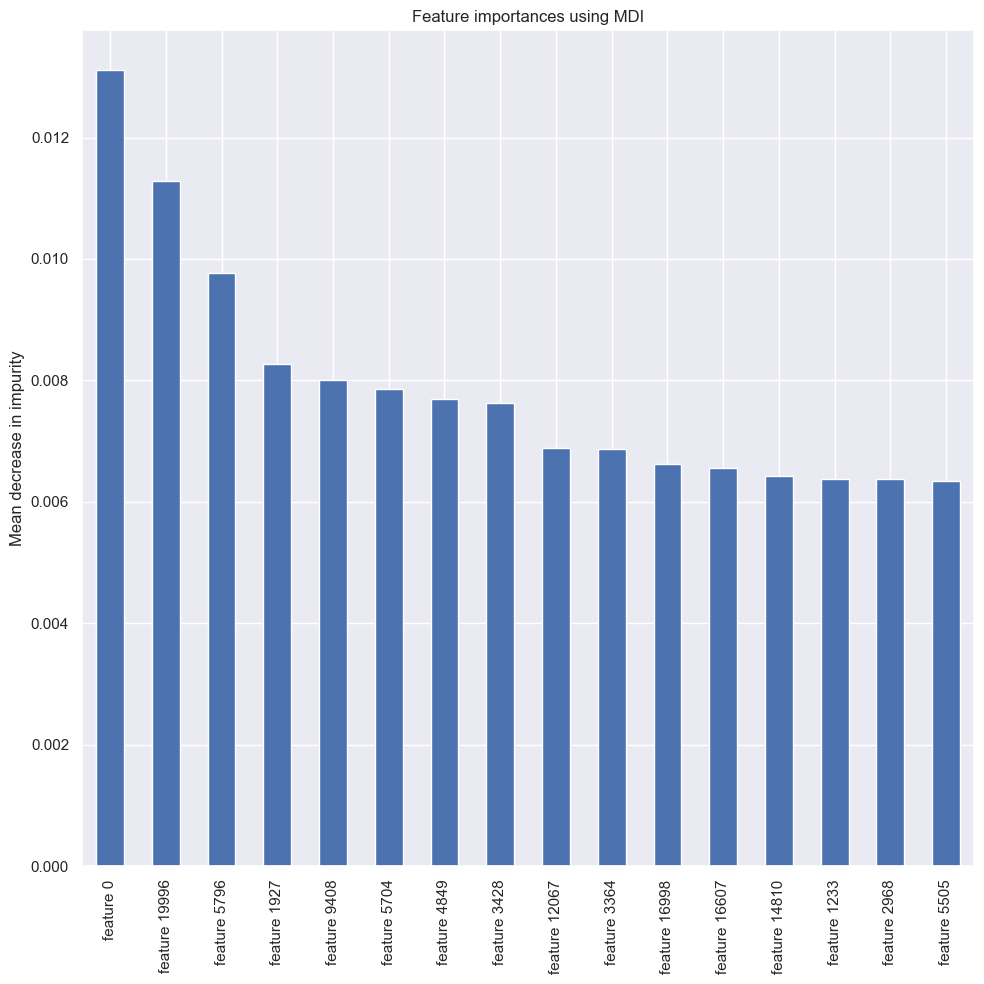

In [12]:
import pandas as pd

forest_importances = pd.Series(importances[np.argsort(-importances)[:16]], index=feature_names[np.argsort(-importances)[:16]])

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# SVC on selected features

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train[:, evolved_estimator.support_][:, new_estimator.support_], y_train)
clf.score(X_test[:, evolved_estimator.support_][:, new_estimator.support_], y_test)